In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from tensorflow import keras
(x_train, __), (x_test, __) = keras.datasets.mnist.load_data()

def g(f,d,lam): # fresnel propagation
  # f: propagated image
  # d: propagation distance (pixels)
  # lam: wavelength (pixels)
  zPad = np.int(4*np.abs(d*lam))
  inF = np.zeros(np.add(f.shape,[zPad,zPad])).astype('complex128')
  inF[np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2),np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2)] = f
  urange = np.linspace(-lam/2,lam/2,inF.shape[0])
  u,v = np.meshgrid(urange,urange)
  g = np.fft.ifft2(np.fft.fft2(inF)*np.fft.fftshift(np.exp(1j *2* np.pi *(d/lam)*np.sqrt( 1 - u**2 - v**2))))
  return g

In [ ]:
target_size = 20000 # um
target_pixel = 314 # pixel
umperpix = target_size / target_pixel
lam = 0.532 / umperpix
d1 = 1028 * 1000. / umperpix
d2 = 1066.24 * 1000. / umperpix

w0 = 1 / umperpix
shift_from_target = int(39.4*1000 / umperpix)
urange = np.arange(shift_from_target-500, shift_from_target+500)
vrange = np.arange(-500, 500)
UU,VV = np.meshgrid(urange,vrange)

In [ ]:
shift_from_target

618

In [ ]:
spot_shift_x = np.array([-5000, 0, 5000]) / umperpix
spot_shift_y = np.array([-5000, 0, 5000]) / umperpix

gaussian_spots = np.zeros((len(spot_shift_y), len(spot_shift_x), 1000, 1000)).astype(np.complex128)

for idx, i in  enumerate(spot_shift_x):
  for idy, j in enumerate(spot_shift_y):
    gg = np.exp(-1j*np.pi/4)*np.exp(1j*2*np.pi*d1/lam)*np.exp(-np.pi*((UU+i)**2+(VV+j)**2)/(w0**2+1j*lam*d1))/(w0**2+1j*lam*d1)
    gaussian_spots[idy,idx,:,:] = gg

gaussian_spots.shape

(3, 3, 1000, 1000)

In [ ]:
mask = cv2.imread('test.jpg', 0)
# mask = x_train[0,:,:]
mask = cv2.resize(mask, (314,314))
h_pad, w_pad = 343, 343
mask = np.pad(mask, ((h_pad,h_pad), (w_pad,w_pad))).astype(np.complex128)
fields_at_target = np.zeros_like(gaussian_spots)

for i in range(len(spot_shift_x)):
  for j in range(len(spot_shift_y)):
    a = gaussian_spots[j,i,:,:] * mask
    a[:h_pad] = 0.
    a[-h_pad:] = 0.
    a[:,:w_pad] = 0.
    a[:,-w_pad:] = 0.
    fields_at_target[j,i,:,:] = a

fields_at_target.shape

(3, 3, 1000, 1000)

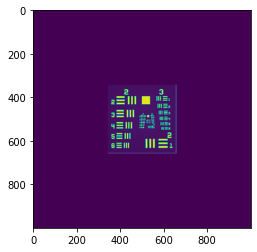

In [ ]:
plt.imshow(np.abs(fields_at_target[1,1,:,:]))

In [ ]:
back2wall = np.zeros((len(spot_shift_y),len(spot_shift_x),1559,1559)).astype(np.complex128)
for i in range(len(spot_shift_x)):
  for j in range(len(spot_shift_y)):
    back2wall[j,i,:,:] = g(fields_at_target[j,i,:,:], d2, lam)
back2wall.shape

(3, 3, 1559, 1559)

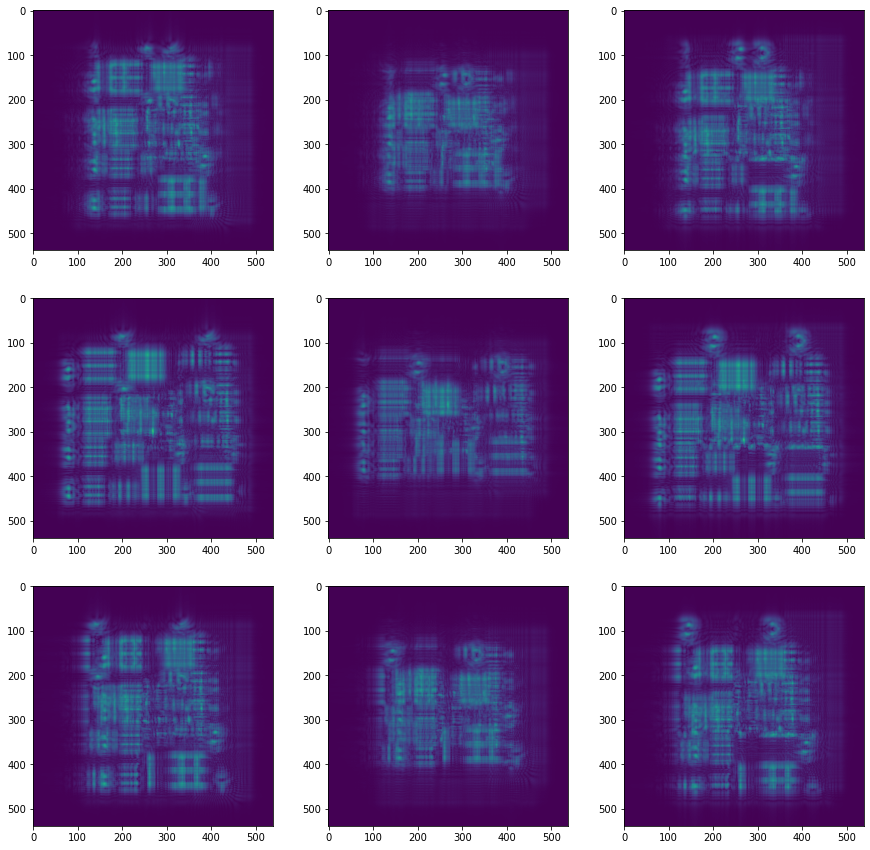

In [ ]:
plt.figure(figsize=(15,15))
k = 1
for i in range(len(spot_shift_x)):
  for j in range(len(spot_shift_y)):
    plt.subplot(len(spot_shift_x),len(spot_shift_y),k)
    plt.imshow(np.abs(back2wall[j,i,:,:])[510:-510, 510:-510])
    k = k+1

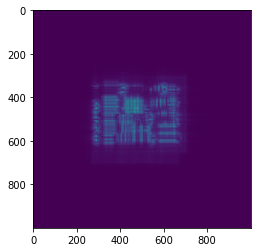

In [ ]:
plt.imshow(np.abs(back2wall[len(spot_shift_y)//2,len(spot_shift_x)//2,:,:][300:1300,300:1300]))

In [ ]:
field_at_target_inv = g(np.abs(back2wall[len(spot_shift_y)//2,len(spot_shift_x)//2,:,:]).astype(np.complex128), -d2, lam)[558:-560,558:-560]
target_est = field_at_target_inv

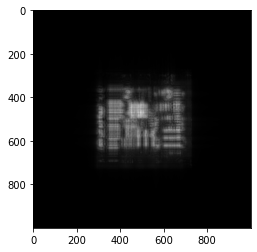

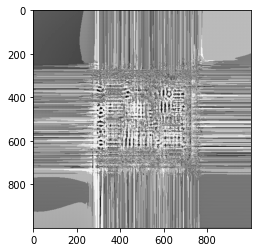

In [ ]:
plt.imshow(np.abs(target_est), cmap='gray')
plt.show()
plt.imshow(np.angle(target_est), cmap='gray')
plt.show()

In [ ]:
power = np.sqrt(np.sum(np.abs(back2wall)**2)/(len(spot_shift_x) * len(spot_shift_y)))
target_est = power * target_est / np.sqrt(np.sum(np.abs(target_est)**2))

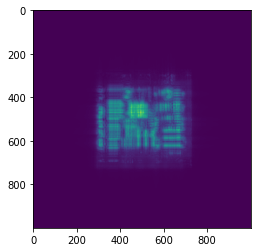

In [ ]:
plt.imshow(np.abs(target_est))

In [ ]:
measurements_est = np.zeros_like(back2wall)
for i in range(len(spot_shift_x)):
  for j in range(len(spot_shift_y)):
    measurements_est[j,i,:,:] = np.abs(back2wall[j,i,:,:]).astype(np.complex128)

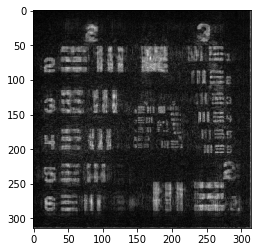

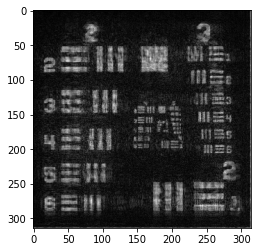

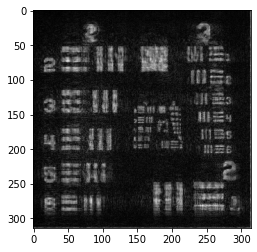

In [ ]:
n = 3
for iter in range(n):
    for i in range(len(spot_shift_x)):
        for j in range(len(spot_shift_y)):
            field_at_target = gaussian_spots[j,i,:,:] * target_est
            field_at_target[:h_pad] = 0.
            field_at_target[-h_pad:] = 0.
            field_at_target[:,:w_pad] = 0.
            field_at_target[:,-w_pad:] = 0.
            
            sc = g(field_at_target, d2, lam)
            measurements_est[j,i,:,:] = np.abs(back2wall[j,i,:,:]).astype(np.complex128)*np.exp(1j*np.angle(sc))
            field_at_target_inv = g(measurements_est[j,i,:,:], -d2, lam)[558:-560,558:-560]
            target_est = 0.9*target_est + 0.1*field_at_target_inv/gaussian_spots[j,i,:,:]
            target_est = power * target_est / np.sqrt(np.sum(np.abs(target_est)**2))

    plt.imshow(np.abs(target_est)[343:343+314,343:343+314], cmap='gray')
    plt.show()

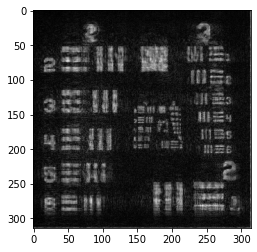

In [ ]:
plt.imshow(np.abs(target_est)[343:343+314,343:343+314], cmap='gray')